In [3]:
import numpy as np
import pandas as pd

import statistics as st
from statistics import mean, pstdev
from scipy import stats
import random, copy, mytools

from matplotlib import gridspec, patches
import matplotlib.pyplot as plt


TRIALS_N, EPISODES_N = 30, 15
ALPHA1, ALPHA2, BETA, GAMMA, TAU = 0.3, 0.3, 0.5, 0.9, 500

mouth0_i, mouth2_i, COST = 0.05, 15.0, 0.02
MOUTHS_L = [mouth0_i, 0, mouth2_i]  # [minor intake, the others, major intake]
STATES_N = 8  # number of states

H_AST, H_INIT = 200, 100  # ideal internal state, initial internal state
M, N = 3, 4  # free parameters of the homeostatic space

IOTA_C, HIGH_IOTA_C, LOW_IOTA_C = 1.0, 1.01, 0.7
HIGH_BETA_C, LOW_BETA_C, HIGH_GAMMA_C, LOW_GAMMA_C = BETA * 1.05, BETA * 0.95, 0.99, 0

CONDITIONS_L = ['control', 'high\niota', 'low\niota', 'high\nbeta', 'low\nbata', 'high\ngamma', 'low\ngamma']
last_qs_l, last_khs_l = [[0, 0] for i in range(STATES_N)], [[0, 0] for i in range(STATES_N)]

In [4]:
class MountClimbHRL:
    def __init__(self, condition=CONDITIONS_L[0]):
        self.a = []  # actions; 0 or 1
        self.A_INIT = -1  # -1: action not conducted, 0: actions without loss, 1: action with loss
        self.d, self.d_est = [], []  # d(Ht), d(Ht+1)
        self.H_AST, self.H_INIT = H_AST, H_INIT  # setpoint, initial internal state (H)
        self.h, self.atten = [self.H_INIT], []  # initializing a list for internal state (H)  # attenuation rates of H
        self.STATES_N = STATES_N  # number of states

        self.k, self.kh = [], [last_khs_l]  # k, k^[action 0, action 1]

        # q[timestep][state][action] = int
        self.q = [last_qs_l]
        self.q_prime = [[[None, None] for i in range(self.STATES_N)]]

        self.p, self.r, self.s = [], [], [0]  # probability for actions of each timestep  # reward  # state {0 ~ STATES_N}
        self.M, self.N, self.condition, self.conditions_l = M, N, condition, CONDITIONS_L
        self.alpha1, self.alpha2, self.beta, self.gamma, self.iota = ALPHA1, ALPHA2, BETA, GAMMA, IOTA_C

        if self.condition == self.conditions_l[1]:  # 'high_iota'
            self.iota = HIGH_IOTA_C
        elif self.condition == self.conditions_l[2]:  # 'low_iota'
            self.iota = LOW_IOTA_C
        elif self.condition == self.conditions_l[3]:  # 'high_beta'
            self.beta = HIGH_BETA_C
        elif self.condition == self.conditions_l[4]:  # 'low_beta'
            self.beta = LOW_BETA_C
        elif self.condition == self.conditions_l[5]:  # 'high_gamma'
            self.gamma = HIGH_GAMMA_C
        elif self.condition == self.conditions_l[6]:  # 'low_gamma'
            self.gamma = LOW_GAMMA_C

        self.tau, self.mouths_l, self.cost = TAU, MOUTHS_L, COST
        self.d.append(((abs(self.H_AST - self.h[-1])) ** self.N) ** (1 / self.M))
        self.d_est.append(((self.iota * (abs(self.H_AST - self.h[-1]))) ** self.N) ** (1 / self.M))
        self.r_1epi = 0  # sum of rewards through each episodes


    def softmax(self):
        for state_i in range(self.STATES_N):
            for action_j in range(2):
                self.q_prime[-1][state_i][action_j] = self.q[-1][state_i][action_j]

        max_q = max(self.q_prime[-1][self.s[-1]][0] * self.beta, self.q_prime[-1][self.s[-1]][1] * self.beta)
        sigma = np.exp((self.q_prime[-1][self.s[-1]][0] * self.beta) - max_q) + np.exp((self.q_prime[-1][self.s[-1]][1] * self.beta) - max_q)

        vals = []
        self.p.append([0, 0])
        for action_i in range(2):
            softmax = np.exp(self.q_prime[-1][self.s[-1]][action_i] * self.beta) / sigma
            vals.append(softmax)
            if action_i == 0:
                self.p[-1][0] = vals[0]
            elif action_i == 1:
                self.p[-1][1] = vals[1]
        dice = random.random()
        if dice <= vals[0]:
            self.a.append(int(0))
        elif vals[0] < dice:
            self.a.append(int(1))


    def update_kh(self):
        self.kh.append(self.kh[-1])  # copy all kh_t to kh_t+1 and initialize the following values of Kh
        if self.s[-1] == 0:  # state 0
            if self.a[-1] == 0:  # action 00 (small intake)
                self.k.append(self.mouths_l[1])  # k > 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(0)
            else:  # action 01 (move horizontally, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(1)
        elif self.s[-1] == 1:  # state 1
            if self.a[-1] == 0:  # action 10 (move horizontally, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(0)
            else:  # action 11 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(2)
        elif self.s[-1] == 2:  # state 2
            if self.a[-1] == 0:  # action 20 (move horizontally, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(1)
            else:  # action 21 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(3)
        elif self.s[-1] == 3:  # state 3
            if self.a[-1] == 0:  # action 30 (descend, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(2)
            else:  # action 31 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(4)
        elif self.s[-1] == 4:  # state 4
            if self.a[-1] == 0:  # action 40 (move horizontally, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(3)
            else:  # action 41 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(5)
        elif self.s[-1] == 5:  # state 5
            if self.a[-1] == 0:  # action 50 (descend, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(4)
            else:  # action 51 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(6)
        elif self.s[-1] == 6:  # state 6
            if self.a[-1] == 0:  # action 60 (descend, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(5)
            else:  # action 61 (climb, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(7)
        elif self.s[-1] == 7:  # state 7
            if self.a[-1] == 0:  # action 70 (descend, no intake)
                self.k.append(self.mouths_l[0])  # k = 0
                self.kh[-1][self.s[-1]][0] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][0] + self.alpha1 * self.k[-1]
                self.s.append(6)
            else:  # action 71 (large intake)
                self.k.append(self.mouths_l[2])  # k = mouths_l[2]
                self.kh[-1][self.s[-1]][1] = (1 - self.alpha1) * self.kh[-2][self.s[-1]][1] + self.alpha1 * self.k[-1]
                self.s.append(7)


    def get_drive(self):
        if self.s[-2] == 0:
            if self.a[-1] == 0:  # do nothing
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][0])) ** self.N) ** (1 / self.M))
            else:  # move horizontally
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][1])) ** self.N) ** (1 / self.M))
        elif self.s[-2] == 1:
            if self.a[-1] == 0:  # climb
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][0])) ** self.N) ** (1 / self.M))
            else:  # move horizontally
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1] - self.cost
                                            - self.kh[-1][self.s[-2]][1])) ** self.N) ** (1 / self.M))
        elif self.s[-2] in [2, 3, 4, 5, 6]:
            if self.a[-1] == 0:  # climb
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][0])) ** self.N) ** (1 / self.M))
            else:  # descend
                self.atten.append(0)  # all 0
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1] - self.cost
                                            - self.kh[-1][self.s[-2]][1])) ** self.N) ** (1 / self.M))
        elif self.s[-2] == 7:
            if self.a[-1] == 0:  # all 0
                self.atten.append(0)
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][0])) ** self.N) ** (1 / self.M))
            else:  # descend
                self.atten.append(0)  # large intake
                self.d_est.append((self.iota * (abs(self.H_AST - (1 - 1 / self.tau) * self.h[-1]
                                            - self.kh[-1][self.s[-2]][1])) ** self.N) ** (1 / self.M))

    def update_h(self):
        self.h.append((1 - 1 / self.tau) * self.h[-1] + self.k[-1] - self.cost * self.atten[-1])
    
    def update_d(self):
        self.d.append(((self.iota * (abs(self.H_AST - self.h[-1]))) ** self.N) ** (1 / self.M))
    
    def get_r(self):
        self.r.append(self.d_est[-2] - self.d_est[-1])
    
    def update_q(self):  # update q about only selected action
        self.q.append(copy.deepcopy(self.q[-1]))
        if self.s[-1] == 7 and self.a[-1] == 1:  # ternimal of a episode
            self.q[-1][self.s[-2]][self.a[-1]] = self.q[-2][self.s[-2]][self.a[-1]] + self.alpha2 * (self.r[-1] - self.q[-2][self.s[-2]][self.a[-1]])            
        else:
            self.q[-1][self.s[-2]][self.a[-1]] = self.q[-2][self.s[-2]][self.a[-1]] + self.alpha2 * (self.r[-1] + self.gamma * max(self.q[-2][self.s[-1]][0], self.q[-2][self.s[-1]][1]) - self.q[-2][self.s[-2]][self.a[-1]])



class OneEpisode():
    def __init__(self, condition, last_qs_l, last_khs_l, CLASS=MountClimbHRL()):
        self.condition, self.CLASS = condition, CLASS
        self.EPISODES_N = EPISODES_N
        self.intake_ns_l, self.episode_classes_l = [], []  # a class representing an episode
        self.sums_r_with_intake_l, self.sums_r_in_epi_l = [], []
        # sum of reward only with INTAKE (not with DO NOTHING), # sum of reward and punishment through episode
        self.history_ite_ns_each_epi_l, self.iter_bs_l = [], []
        # history for number of iterations during each episode  # episode initiated; True. False; an episode ends
        self.last_qs_l, self.last_khs_l = last_qs_l, last_khs_l  # inheriting variables between episodes


    def execute(self):
        a_intakes_line_l = []
        # j is an episode.
        copied_class = copy.deepcopy(self.CLASS)
        self.episode_classes_l.append(copied_class)
        self.episode_classes_l[-1].q.append(self.last_qs_l), self.episode_classes_l[-1].kh.append(self.last_khs_l)
        self.history_ite_ns_each_epi_l.append(0)
        self.iter_bs_l.append(True)
        
        while self.iter_bs_l[-1]:
            # a timepoint
            self.episode_classes_l[-1].softmax()

            if self.episode_classes_l[-1].a[-1] == 1 and self.episode_classes_l[-1].s[-1] == 7:
                self.episode_classes_l[-1].update_kh()
                self.episode_classes_l[-1].get_drive()
                self.episode_classes_l[-1].update_h()
                self.episode_classes_l[-1].update_d()
                self.episode_classes_l[-1].get_r()
                self.episode_classes_l[-1].update_q()
                
                self.history_ite_ns_each_epi_l[-1] += 1

                self.iter_bs_l.append(False)
                break
                        
            self.episode_classes_l[-1].update_kh()
            self.episode_classes_l[-1].get_drive()
            self.episode_classes_l[-1].update_h()
            self.episode_classes_l[-1].update_d()
            self.episode_classes_l[-1].get_r()
            self.episode_classes_l[-1].update_q()
            self.history_ite_ns_each_epi_l[-1] += 1
            
        a_intakes_line_l.append([])

In [5]:
his_hs_d, his_qs_d, his_ss_d, his_as_d, his_khs_d, his_rs_d, his_ds_d = {}, {}, {}, {}, {}, {}, {}
his_ds_l = [his_hs_d, his_qs_d, his_ss_d, his_as_d, his_khs_d, his_rs_d, his_ds_d]

for variab_i in range(len(his_ds_l)):
    for condition_j in CONDITIONS_L:
        his_ds_l[variab_i][condition_j] = []
        for trial_k in range(TRIALS_N):
            his_ds_l[variab_i][condition_j].append([])  # episode list


# REF：his_ds_l[var][condition][trial][episode][timestep][state][action]
for condition_i in CONDITIONS_L:
    for trial_j in range(TRIALS_N):
        last_qs_l, last_khs_l = [[0, 0] for _ in range(STATES_N)], [[0, 0] for _ in range(STATES_N)]
        for episode_k in range(EPISODES_N):
            climb_inst = MountClimbHRL(condition_i)
            episode_inst = OneEpisode(condition_i, last_qs_l, last_khs_l, climb_inst)
            episode_inst.execute()

            his_ds_l[0][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].h)
            his_ds_l[1][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].q)
            his_ds_l[2][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].s)
            his_ds_l[3][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].a)
            his_ds_l[4][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].kh)
            his_ds_l[5][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].r)
            his_ds_l[6][condition_i][trial_j].append(episode_inst.episode_classes_l[-1].d)

            last_qs_l = episode_inst.episode_classes_l[-1].q[-1]
            last_khs_l = episode_inst.episode_classes_l[-1].kh[-1]

In [6]:
def count_summits(list_1d, num):
    output = 0
    for e in list_1d:
        if e == num:
            output += 1
    return output

def calc_perf_one_cond(input_l, condition):
    numerators_l, denominators_l = [], []
    fractions_performance = []
    
    for trial_j in range(TRIALS_N):
        numerators_l.append([])
        denominators_l.append([])
        for episode_k in range(EPISODES_N):
            numerators_l[trial_j].append(count_summits(input_l[2][condition][trial_j][episode_k], STATES_N - 1) - 1)
            denominators_l[trial_j].append(len(input_l[2][condition][trial_j][episode_k]) - 1)
        fractions_performance.append(sum(numerators_l[trial_j]) / sum(denominators_l[trial_j]))

    sums_timestep_performance = []
    for trial_i in range(TRIALS_N):
        sums_timestep_performance.append(sum(denominators_l[trial_i]))

    return [[fractions_performance, stats.shapiro(fractions_performance)], [sums_timestep_performance, stats.shapiro(sums_timestep_performance)]]

'\ndef perfs_histogram(input_l):\n    hist_perfs = plt.figure(figsize=(5, 15))\n    axes_hists_l = [[None for _ in range(len(CONDITIONS_L))] for _ in range(2)]\n    range_perfs_l = [[], []]\n\n    for condition_i in CONDITIONS_L:\n        range_perfs_l[0].append(calc_perf_one_cond(input_l, CONDITIONS_L[condition_i])[0][0])\n        range_perfs_l[1].append(calc_perf_one_cond(input_l, CONDITIONS_L[condition_i])[1][0])\n    starges_bins = np.log2(TRIALS_N) + 1\n    bin_width_perfs = (max(range_perfs_l[1]) - min(range_perfs_l[0])) / starges_bins\n\n    for condition_i in CONDITIONS_L:\n        data_perfs_hisogram = calc_perf_one_cond(input_l, CONDITIONS_L[condition_i])\n        data_perfs_hisogram\n\n    \n    #2*7のヒストグラムをプロット\n'

In [7]:
def all_cond_test_normal(input_l):
    all_cond_test_normal_d = {}
    paramet_bs_l = [True, True]
    for condition_e in CONDITIONS_L:
        all_cond_test_normal_d[condition_e] = calc_perf_one_cond(input_l, condition_e)
        sute0, fract_perf_normal_p = all_cond_test_normal_d[condition_e][0][1]
        sute1, sum_perf_normal_p = all_cond_test_normal_d[condition_e][1][1]

        if fract_perf_normal_p < 0.05:
            paramet_bs_l[0] = False
        if sum_perf_normal_p < 0.05:
            paramet_bs_l[1] = False

    return [paramet_bs_l, all_cond_test_normal_d]


def test_perform_conditions(input_l):
    all_cond_test_normal_l = all_cond_test_normal(input_l)
    control_data = all_cond_test_normal_l[1][CONDITIONS_L[0]]
    output = []

    if all_cond_test_normal_l[0][0]:
        ttest_tstats_fract_d, ttest_ps_fract_d = {}, {}
        for i in range(len(CONDITIONS_L)):
            ttest_tstats_fract_d[CONDITIONS_L[i]], ttest_ps_fract_d[CONDITIONS_L[i]] = stats.ttest_ind(control_data[0][0], all_cond_test_normal_l[1][CONDITIONS_L[i]][0][0])
        output.append(['t_test', 't_stats', ttest_tstats_fract_d, 'p-val', ttest_ps_fract_d])

    else:
        kruskal_stats_fract_d, kruskal_ps_fract_d = {}, {}
        for i in range(len(CONDITIONS_L)):
            kruskal_stats_fract_d[CONDITIONS_L[i]], kruskal_ps_fract_d[CONDITIONS_L[i]] = stats.kruskal(control_data[1][0], all_cond_test_normal_l[1][CONDITIONS_L[i]][1][0])
        output.append(['kruskal', 'stats', kruskal_stats_fract_d, 'p-val', kruskal_ps_fract_d])

    if all_cond_test_normal_l[0][1]:
        ttest_tstats_sum_d, ttest_ps_sum_d = {}, {}
        for i in range(len(CONDITIONS_L)):
            ttest_tstats_sum_d[CONDITIONS_L[i]], ttest_ps_sum_d[CONDITIONS_L[i]] = stats.ttest_ind(control_data[0][0], all_cond_test_normal_l[1][CONDITIONS_L[i]][0][0])        
        output.append(['t_test', 't_stats', ttest_tstats_sum_d, 'p-val', ttest_ps_sum_d])

    else:
        kruskal_stats_sum_d, kruskal_ps_sum_d = {}, {}
        for i in range(len(CONDITIONS_L)):
            kruskal_stats_sum_d[CONDITIONS_L[i]], kruskal_ps_sum_d[CONDITIONS_L[i]] = stats.kruskal(control_data[1][0], all_cond_test_normal_l[1][CONDITIONS_L[i]][1][0])
        output.append(['kruskal', 'stats', kruskal_stats_sum_d, 'p-val', kruskal_ps_sum_d])

    return output


In [8]:
def calc_mu_sigma_conds(input_l):
    numerators_d, denominators_d = {}, {}
    calc_mu_fractions_performance_d = {}
    for condition_e in CONDITIONS_L:
        numerators_d[condition_e] = []
        denominators_d[condition_e] = []
        calc_mu_fractions_performance_d[condition_e] = []
        for trial_j in range(TRIALS_N):
            numerators_d[condition_e].append([])
            denominators_d[condition_e].append([])
            for episode_k in range(EPISODES_N):
                numerators_d[condition_e][trial_j].append(count_summits(input_l[2][condition_e][trial_j][episode_k], STATES_N - 1) - 1)
                denominators_d[condition_e][trial_j].append(len(input_l[2][condition_e][trial_j][episode_k]) - 1)
            calc_mu_fractions_performance_d[condition_e].append(sum(numerators_d[condition_e][trial_j]) / sum(denominators_d[condition_e][trial_j]))

    sums_timestep_performance_d = {}
    for condition_e in CONDITIONS_L:
        sums_timestep_performance_d[condition_e] = []
        for trial_i in range(TRIALS_N):
            sums_timestep_performance_d[condition_e].append(sum(denominators_d[condition_e][trial_i]))

    return calc_mu_fractions_performance_d, sums_timestep_performance_d

In [9]:
def performs_bar_graphs(input_l):
    fractions_performance_d, sums_timestep_performance_d = calc_mu_sigma_conds(input_l)
    fractions_means_l, fractions_sds_l = [], []
    sums_means_l, sums_sds_l = [], []

    for condition_e in CONDITIONS_L:
        fractions_means_l.append(st.mean(fractions_performance_d[condition_e]))
        fractions_sds_l.append(st.stdev(fractions_performance_d[condition_e]))
        sums_means_l.append((st.mean(sums_timestep_performance_d[condition_e])))
        sums_sds_l.append(st.stdev(sums_timestep_performance_d[condition_e]))

    test_results = test_perform_conditions(input_l)

    x = list(range(len(CONDITIONS_L)))
    colors = ['black', 'darkred', 'lightcoral', 'darkblue', 'lightblue', 'darkgrey', 'lightgrey']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(len(x)):
        ax1.bar(x[i], fractions_means_l[i], yerr=fractions_sds_l[i], capsize=5, color=colors[i])

        if i != 0:
            if test_results[0][4][CONDITIONS_L[i]] < 0.001:
                ax1.annotate('***', xy=(x[i], fractions_means_l[i] + fractions_sds_l[i]), ha='center', va='bottom')
            elif test_results[0][4][CONDITIONS_L[i]] < 0.01:
                ax1.annotate('**', xy=(x[i], fractions_means_l[i] + fractions_sds_l[i]), ha='center', va='bottom')
            elif test_results[0][4][CONDITIONS_L[i]] < 0.05:
                ax1.annotate('*', xy=(x[i], fractions_means_l[i] + fractions_sds_l[i]), ha='center', va='bottom')
            else:
                ax1.annotate('N.S.', xy=(x[i], fractions_means_l[i] + fractions_sds_l[i]), ha='center', va='bottom')

    ax1.set_title('Fractions')
    ax1.set_xlabel('Conditions')
    ax1.set_ylabel('Fract. perform.')
    ax1.set_xticks(x)
    ax1.set_xticklabels(CONDITIONS_L)


    for i in range(len(x)):
        ax2.bar(x[i], sums_means_l[i], yerr=sums_sds_l[i], capsize=5, color=colors[i])

        if i != 0:
            if test_results[1][4][CONDITIONS_L[i]] < 0.001:
                ax2.annotate('***', xy=(x[i], sums_means_l[i] + sums_sds_l[i]), ha='center', va='bottom')
            elif test_results[1][4][CONDITIONS_L[i]] < 0.01:
                ax2.annotate('**', xy=(x[i], sums_means_l[i] + sums_sds_l[i]), ha='center', va='bottom')
            elif test_results[1][4][CONDITIONS_L[i]] < 0.05:
                ax2.annotate('*', xy=(x[i], sums_means_l[i] + sums_sds_l[i]), ha='center', va='bottom')
            else:
                ax2.annotate('N.S.', xy=(x[i], sums_means_l[i] + sums_sds_l[i]), ha='center', va='bottom')

    ax2.set_title('Sums')
    ax2.set_xlabel('Conditions')
    ax2.set_ylabel('Sums. perform.')
    ax2.set_xticks(x)
    ax2.set_xticklabels(CONDITIONS_L)

    plt.tight_layout()
    plt.show()


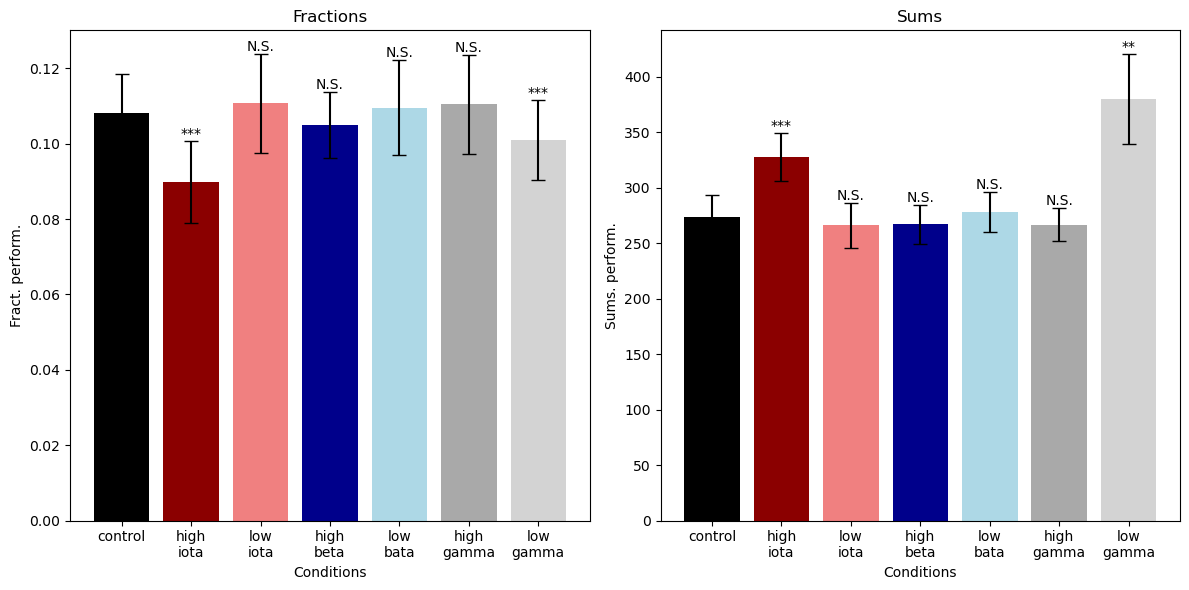

In [10]:
performs_bar_graphs(his_ds_l)

In [11]:
def visu_groups_timecourse(input_l, visu_episode):
    
    VISU_VARIABLES_N, FS_N, VISU_EPISODE = 9, 8, visu_episode
    gspec = gridspec.GridSpec(ncols=len(CONDITIONS_L), nrows=VISU_VARIABLES_N, height_ratios=[1]*VISU_VARIABLES_N)
    fig = plt.figure(figsize=(15, 12))
 
    axes_l = [[None for _ in range(len(CONDITIONS_L))] for _ in range(VISU_VARIABLES_N)]
    
    for visu_variable_i in range(VISU_VARIABLES_N):
        for group_i in range(len(CONDITIONS_L)):
            axes_l[visu_variable_i][group_i] = fig.add_subplot(gspec[visu_variable_i, group_i])

    CONDITIONS_L[group_i] = CONDITIONS_L[group_i]

    for group_i in range(len(CONDITIONS_L)):
        axes_l[0][group_i].hlines(H_AST, 0, len(input_l[0][CONDITIONS_L[group_i]][0][VISU_EPISODE]), linestyle="dashed")
        axes_l[0][group_i].hlines(H_INIT*.9, 0, len(input_l[0][CONDITIONS_L[group_i]][0][VISU_EPISODE]), linestyle="dashed", color='white')
        axes_l[0][group_i].plot(input_l[0][CONDITIONS_L[group_i]][0][VISU_EPISODE], linewidth=2, color='#00BFFF')
        axes_l[0][group_i].tick_params(labelbottom=False)

        l00 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][0][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l10 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][1][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l20 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][2][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l30 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][3][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l40 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][4][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l50 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][5][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l60 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][6][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l70 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][7][0] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]

        axes_l[1][group_i].plot(l00, linewidth=2, color='blue', alpha=1.0)
        axes_l[1][group_i].plot(l10, linewidth=2, color='blue', alpha=0.7)
        axes_l[1][group_i].plot(l20, linewidth=2, color='blue', alpha=0.4)
        axes_l[1][group_i].plot(l30, linewidth=2, color='blue', alpha=0.1)
        axes_l[1][group_i].plot(l40, linewidth=2, color='red', alpha=0.1)
        axes_l[1][group_i].plot(l50, linewidth=2, color='red', alpha=0.4)
        axes_l[1][group_i].plot(l60, linewidth=2, color='red', alpha=0.7)
        axes_l[1][group_i].plot(l70, linewidth=2, color='red', alpha=1.0)
        axes_l[1][group_i].tick_params(labelbottom=False)

        l01 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][0][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l11 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][1][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l21 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][2][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l31 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][3][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l41 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][4][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l51 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][5][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l61 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][6][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        l71 = [input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][7][1] for i in range(len(input_l[1][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]

        axes_l[2][group_i].plot(l01, linewidth=2, color='blue', alpha=1.0)
        axes_l[2][group_i].plot(l11, linewidth=2, color='blue', alpha=0.7)
        axes_l[2][group_i].plot(l21, linewidth=2, color='blue', alpha=0.4)
        axes_l[2][group_i].plot(l31, linewidth=2, color='blue', alpha=0.1)
        axes_l[2][group_i].plot(l41, linewidth=2, color='red', alpha=0.1)
        axes_l[2][group_i].plot(l51, linewidth=2, color='red', alpha=0.4)
        axes_l[2][group_i].plot(l61, linewidth=2, color='red', alpha=0.7)
        axes_l[2][group_i].plot(l71, linewidth=2, color='red', alpha=1.0)
        axes_l[2][group_i].tick_params(labelbottom=False)


        axes_l[3][group_i].plot(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE], linewidth=2, color='#00BFFF')
        axes_l[3][group_i].hlines(0, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(1, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(2, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(3, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(4, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(5, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(6, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].hlines(7, 0, len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[3][group_i].scatter(list(range(len(input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE]))), input_l[2][CONDITIONS_L[group_i]][0][VISU_EPISODE], s=10, c='blue')
        axes_l[3][group_i].set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
        axes_l[3][group_i].tick_params(labelbottom=False)


        axes_l[4][group_i].hlines(0, 0, len(his_ds_l[3][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[4][group_i].hlines(1, 0, len(his_ds_l[3][CONDITIONS_L[group_i]][0][VISU_EPISODE]))
        axes_l[4][group_i].scatter(list(range(len(his_ds_l[3][CONDITIONS_L[group_i]][0][VISU_EPISODE]))), his_ds_l[3][CONDITIONS_L[group_i]][0][VISU_EPISODE], s=10, c='red')
        axes_l[4][group_i].set_yticks([0, 1])
        axes_l[4][group_i].tick_params(labelbottom=False)

        kh00 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][0][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh10 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][1][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh20 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][2][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh30 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][3][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh40 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][4][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh50 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][5][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh60 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][6][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh70 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][7][0] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]

        axes_l[5][group_i].plot(kh00, linewidth=2, color='blue', alpha=1.0)
        axes_l[5][group_i].plot(kh10, linewidth=2, color='blue', alpha=0.7)
        axes_l[5][group_i].plot(kh20, linewidth=2, color='blue', alpha=0.4)
        axes_l[5][group_i].plot(kh30, linewidth=2, color='blue', alpha=0.1)
        axes_l[5][group_i].plot(kh40, linewidth=2, color='red', alpha=0.1)
        axes_l[5][group_i].plot(kh50, linewidth=2, color='red', alpha=0.4)
        axes_l[5][group_i].plot(kh60, linewidth=2, color='red', alpha=0.7)
        axes_l[5][group_i].plot(kh70, linewidth=2, color='red', alpha=1.0)
        axes_l[5][group_i].tick_params(labelbottom=False)


        kh01 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][0][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh11 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][1][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh21 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][2][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh31 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][3][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh41 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][4][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh51 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][5][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh61 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][6][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]
        kh71 = [his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE][i][7][1] for i in range(len(his_ds_l[4][CONDITIONS_L[group_i]][0][VISU_EPISODE]))]

        axes_l[6][group_i].plot(kh01, linewidth=2, color='blue', alpha=1.0)
        axes_l[6][group_i].plot(kh11, linewidth=2, color='blue', alpha=0.7)
        axes_l[6][group_i].plot(kh21, linewidth=2, color='blue', alpha=0.4)
        axes_l[6][group_i].plot(kh31, linewidth=2, color='blue', alpha=0.1)
        axes_l[6][group_i].plot(kh41, linewidth=2, color='red', alpha=0.1)
        axes_l[6][group_i].plot(kh51, linewidth=2, color='red', alpha=0.4)
        axes_l[6][group_i].plot(kh61, linewidth=2, color='red', alpha=0.7)
        axes_l[6][group_i].plot(kh71, linewidth=2, color='red', alpha=1.0)
        axes_l[6][group_i].tick_params(labelbottom=False)


        axes_l[7][group_i].hlines(0, 0, len(his_ds_l[5][CONDITIONS_L[group_i]][0][VISU_EPISODE]), linestyle="dashed")
        axes_l[7][group_i].plot(his_ds_l[5][CONDITIONS_L[group_i]][0][VISU_EPISODE], linewidth=2, color='blue')
        axes_l[7][group_i].tick_params(labelbottom=False)


        axes_l[8][group_i].hlines(500, 0, len(his_ds_l[6][CONDITIONS_L[group_i]][0][VISU_EPISODE]), color='white')
        axes_l[8][group_i].hlines(0, 0, len(his_ds_l[6][CONDITIONS_L[group_i]][0][VISU_EPISODE]), linestyle="dashed")
        axes_l[8][group_i].plot(his_ds_l[6][CONDITIONS_L[group_i]][0][VISU_EPISODE], linewidth=2, color='blue')
        

        for variable_i in range(VISU_VARIABLES_N):
            if group_i != 0:
                axes_l[variable_i][group_i].tick_params(labelleft=False)

        if group_i == 0:
            axes_l[0][group_i].set_ylabel('H', fontsize=FS_N)
            axes_l[1][group_i].set_ylabel('Q_0' , fontsize=FS_N)
            axes_l[2][group_i].set_ylabel('Q_1' , fontsize=FS_N)
            axes_l[3][group_i].set_ylabel('State', fontsize=FS_N)
            axes_l[4][group_i].set_ylabel('Action', fontsize=FS_N)
            axes_l[5][group_i].set_ylabel('Kh_0', fontsize=FS_N)
            axes_l[6][group_i].set_ylabel('Kh_1', fontsize=FS_N)
            axes_l[7][group_i].set_ylabel('Reward' , fontsize=FS_N)
            axes_l[8][group_i].set_ylabel('Drive' , fontsize=FS_N)

        axes_l[8][group_i].set_xlabel(str(CONDITIONS_L[group_i]), fontsize=FS_N)

        fig.subplots_adjust(left=0.3)


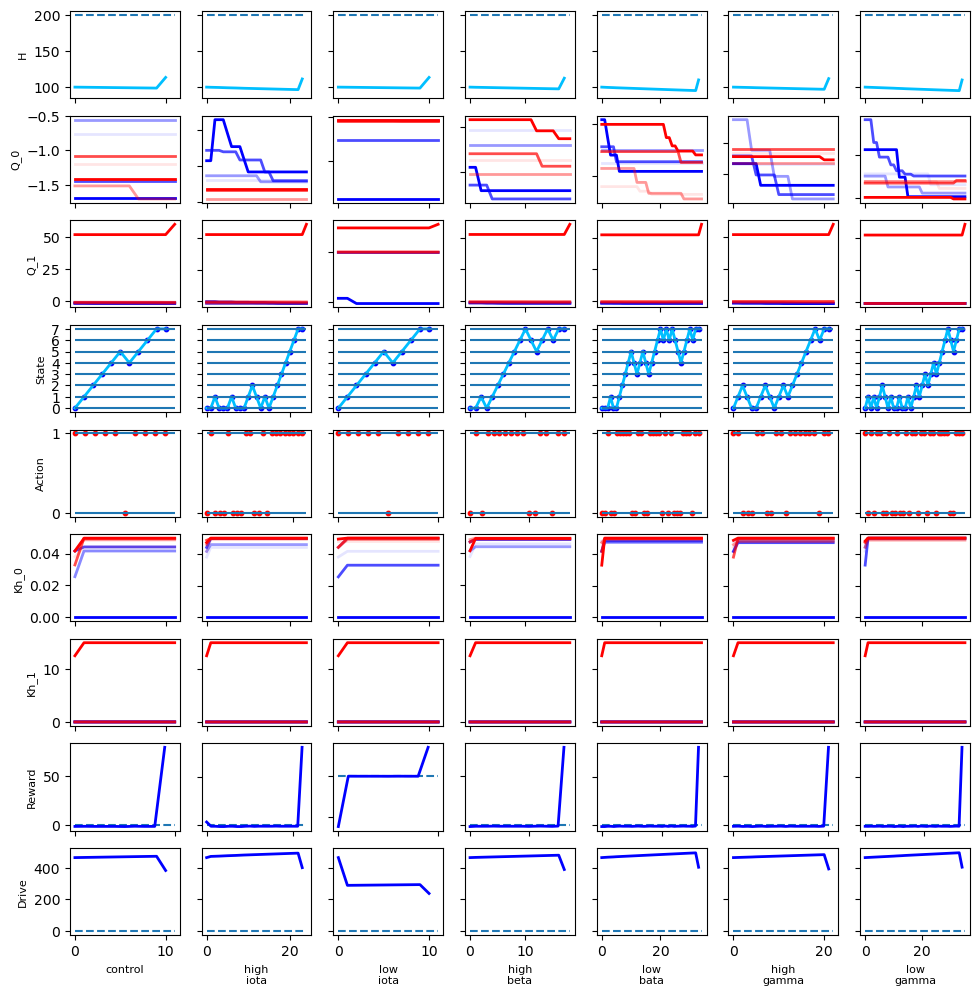

In [12]:
visu_groups_timecourse(his_ds_l, 5)

In [13]:
def lowintakes_bar_graphs(input_l):
    total_lowintakes_d = {}
    for condition_e in CONDITIONS_L:
        total_lowintakes_d[condition_e] = []
        for trial_i in range(TRIALS_N):
            total_lowintakes_d[condition_e].append(0)
            for episode_j in range(EPISODES_N):
                states_l = input_l[2][condition_e][trial_i][episode_j]
                for state_k in states_l:
                    if states_l[state_k] == 0 and input_l[3][condition_e][trial_i][episode_j][state_k] == 0:
                        total_lowintakes_d[condition_e][trial_i] += 1

        NORMALITY_LOWINRTAKE = True

        stat_shapiro, p_shapiro = stats.shapiro(total_lowintakes_d[condition_e])
        if p_shapiro > 0.05:
            NORMALITY_LOWINRTAKE = False

    x = list(range(len(CONDITIONS_L)))
    colors = ['black', 'darkred', 'lightcoral', 'darkblue', 'lightblue', 'darkgrey', 'lightgrey']
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))


    if NORMALITY_LOWINRTAKE:
        ttest_lowintake_ps_d = {}
        lowintake_means_l, lowintake_sds_l = [], []

        for condition_e in CONDITIONS_L:
            lowintake_means_l.append(st.mean(total_lowintakes_d[condition_e]))
            lowintake_sds_l.append(st.stdev(total_lowintakes_d[condition_e]))

        for condition_e in CONDITIONS_L:
            if condition_e != CONDITIONS_L[0]:
                ttest_lowintake_stat, ttest_lowintake_p = stats.ttest_ind(total_lowintakes_d[CONDITIONS_L[0]], total_lowintakes_d[condition_e])
                ttest_lowintake_ps_d[condition_e] = ttest_lowintake_p

        for i in range(len(x)):
            ax1.bar(x[i], lowintake_means_l[i], yerr=lowintake_sds_l[i], capsize=5, color=colors[i])

            if i != 0:
                if ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.001:
                    ax1.annotate('***', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                elif ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.01:
                    ax1.annotate('**', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                elif ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.05:
                    ax1.annotate('*', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                else:
                    ax1.annotate('N.S.', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')


        ax1.set_xlabel('Conditions')
        ax1.set_ylabel('#low intake (a00)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(CONDITIONS_L)


    else:
        wilcoxon_lowintake_ps_d = {}  # wilcoxon_lowintake_ps_d[condition_e] = 0.05
        for condition_e in CONDITIONS_L:
            if condition_e != CONDITIONS_L[0]:
                wilcoxon_lowintake_stat, wilcoxon_lowintake_p = stats.wilcoxon(total_lowintakes_d[CONDITIONS_L[0]], total_lowintakes_d[condition_e])
                wilcoxon_lowintake_ps_d[condition_e] = wilcoxon_lowintake_p

        ax1.boxplot([total_lowintakes_d[CONDITIONS_L[i]] for i in range(len(x))])
        WILCOXON_AST_C = 50

        for i in range(len(x)):
            if i != 0:
                if wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.001:
                    ax1.annotate('***', xy=(x[i], wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] + WILCOXON_AST_C), ha='center', va='bottom')
                elif wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.01:
                    ax1.annotate('**', xy=(x[i], wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] + WILCOXON_AST_C), ha='center', va='bottom')
                elif wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.05:
                    ax1.annotate('*', xy=(x[i], wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] + WILCOXON_AST_C), ha='center', va='bottom')
                else:
                    ax1.annotate('N.S.', xy=(x[i], wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] + WILCOXON_AST_C), ha='center', va='bottom')

        ax1.set_xlabel('Conditions')
        ax1.set_ylabel('#low intake (a00)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(CONDITIONS_L)

    plt.tight_layout()
    plt.show()

In [14]:
def lowintakes_bar_graphs(input_l):
    total_lowintakes_d = {}
    for condition_e in CONDITIONS_L:
        total_lowintakes_d[condition_e] = []
        for trial_i in range(TRIALS_N):
            total_lowintakes_d[condition_e].append(0)
            for episode_j in range(EPISODES_N):
                states_l = input_l[2][condition_e][trial_i][episode_j]
                for state_k in states_l:
                    if states_l[state_k] == 0 and input_l[3][condition_e][trial_i][episode_j][state_k] == 0:
                        total_lowintakes_d[condition_e][trial_i] += 1

        NORMALITY_LOWINRTAKE = True  # normality

        stat_shapiro, p_shapiro = stats.shapiro(total_lowintakes_d[condition_e])
        if p_shapiro > 0.05:
            NORMALITY_LOWINRTAKE = False

    x = list(range(len(CONDITIONS_L)))
    colors = ['black', 'darkred', 'lightcoral', 'darkblue', 'lightblue', 'darkgrey', 'lightgrey']
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))


    if NORMALITY_LOWINRTAKE:
        ttest_lowintake_ps_d = {}  # ttest_lowintake_ps_d[condition_e] = 0.05
        lowintake_means_l, lowintake_sds_l = [], []

        for condition_e in CONDITIONS_L:
            lowintake_means_l.append(st.mean(total_lowintakes_d[condition_e]))
            lowintake_sds_l.append(st.stdev(total_lowintakes_d[condition_e]))

        for condition_e in CONDITIONS_L:
            if condition_e != CONDITIONS_L[0]:
                ttest_lowintake_stat, ttest_lowintake_p = stats.ttest_ind(total_lowintakes_d[CONDITIONS_L[0]], total_lowintakes_d[condition_e])
                ttest_lowintake_ps_d[condition_e] = ttest_lowintake_p

        for i in range(len(x)):
            ax1.bar(x[i], lowintake_means_l[i], yerr=lowintake_sds_l[i], capsize=5, color=colors[i])

            if i != 0:
                if ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.001:
                    ax1.annotate('***', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                elif ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.01:
                    ax1.annotate('**', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                elif ttest_lowintake_ps_d[CONDITIONS_L[i]] < 0.05:
                    ax1.annotate('*', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')
                else:
                    ax1.annotate('N.S.', xy=(x[i], lowintake_means_l[i] + lowintake_sds_l[i]), ha='center', va='bottom')


        ax1.set_xlabel('Conditions')
        ax1.set_ylabel('#low intake (a00)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(CONDITIONS_L)


    else:
        wilcoxon_lowintake_ps_d = {}  # wilcoxon_lowintake_ps_d[condition_e] = 0.05
        xlong = list(range(len(CONDITIONS_L) + 1))
        for condition_e in CONDITIONS_L:
            if condition_e != CONDITIONS_L[0]:
                wilcoxon_lowintake_stat, wilcoxon_lowintake_p = stats.wilcoxon(total_lowintakes_d[CONDITIONS_L[0]], total_lowintakes_d[condition_e])
                wilcoxon_lowintake_ps_d[condition_e] = wilcoxon_lowintake_p
        ax1.boxplot([total_lowintakes_d[CONDITIONS_L[i]] for i in range(len(x))])
        for i in range(len(x)):
            if i != 0:
                if wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.001:
                    ax1.annotate('***', xy=(xlong[i+1], max(total_lowintakes_d[CONDITIONS_L[i]])), ha='center', va='bottom')
                elif wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.01:
                    ax1.annotate('**', xy=(xlong[i+1], max(total_lowintakes_d[CONDITIONS_L[i]])), ha='center', va='bottom')
                elif wilcoxon_lowintake_ps_d[CONDITIONS_L[i]] < 0.05:
                    ax1.annotate('*', xy=(xlong[i+1], max(total_lowintakes_d[CONDITIONS_L[i]])), ha='center', va='bottom')
                else:
                    ax1.annotate('N.S.', xy=(xlong[i+1], max(total_lowintakes_d[CONDITIONS_L[i]])), ha='center', va='bottom')

        ax1.set_xlabel('Conditions')
        ax1.set_ylabel('#low intake (a00)')
        ax1.set_xticks(xlong)
        ax1.set_xticklabels([''] + CONDITIONS_L)

    plt.tight_layout()
    plt.show()

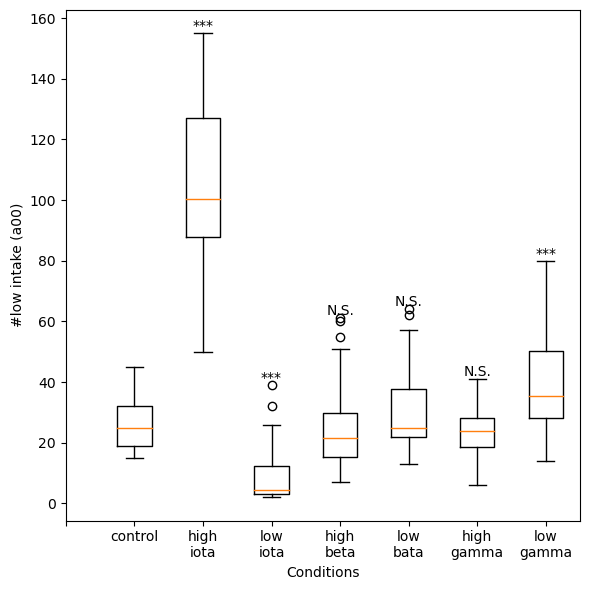

In [15]:
lowintakes_bar_graphs(his_ds_l)